In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.tree import export_graphviz
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)


# 1. Load the Dataset

In [2]:
credit = pd.read_csv('data/german_credit_data.csv')

# 2. Explore the dataset

In [3]:
print("Shape of the dataset:", credit.shape)
print("\nFirst 5 rows:")
print(credit.head())

Shape of the dataset: (1000, 10)

First 5 rows:
   Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  
0           1169         6             radio/TV  
1           5951        48             radio/TV  
2           2096        12            education  
3           7882        42  furniture/equipment  
4           4870        24                  car  


In [4]:
if 'Risk' in credit.columns:
    target_col = 'Risk'
elif 'Class' in credit.columns:
    target_col = 'Class'
elif 'Target' in credit.columns:
    target_col = 'Target'
else:
    # If none of the common names are found, assume the last column is the target
    target_col = credit.columns[-1]

In [5]:
# Identify categorical and numerical columns
categorical_cols = credit.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = credit.select_dtypes(include=['int64', 'float64']).columns.tolist()

if target_col in numerical_cols:
    numerical_cols.remove(target_col)

print(f"\nCategorical columns ({len(categorical_cols)}):", categorical_cols)
print(f"Numerical columns ({len(numerical_cols)}):", numerical_cols)


# Check for missing values
print("\nMissing values:")
print(credit.isnull().sum())

# Get summary statistics
print("\nSummary statistics for numerical features:")
print(credit[numerical_cols].describe())


Categorical columns (5): ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
Numerical columns (5): ['Unnamed: 0', 'Age', 'Job', 'Credit amount', 'Duration']

Missing values:
Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

Summary statistics for numerical features:
        Unnamed: 0          Age          Job  Credit amount     Duration
count  1000.000000  1000.000000  1000.000000    1000.000000  1000.000000
mean    499.500000    35.546000     1.904000    3271.258000    20.903000
std     288.819436    11.375469     0.653614    2822.736876    12.058814
min       0.000000    19.000000     0.000000     250.000000     4.000000
25%     249.750000    27.000000     2.000000    1365.500000    12.000000
50%     499.500000    33.000000     2.000000    2319.500000    18.000000

# 3. Data visualization

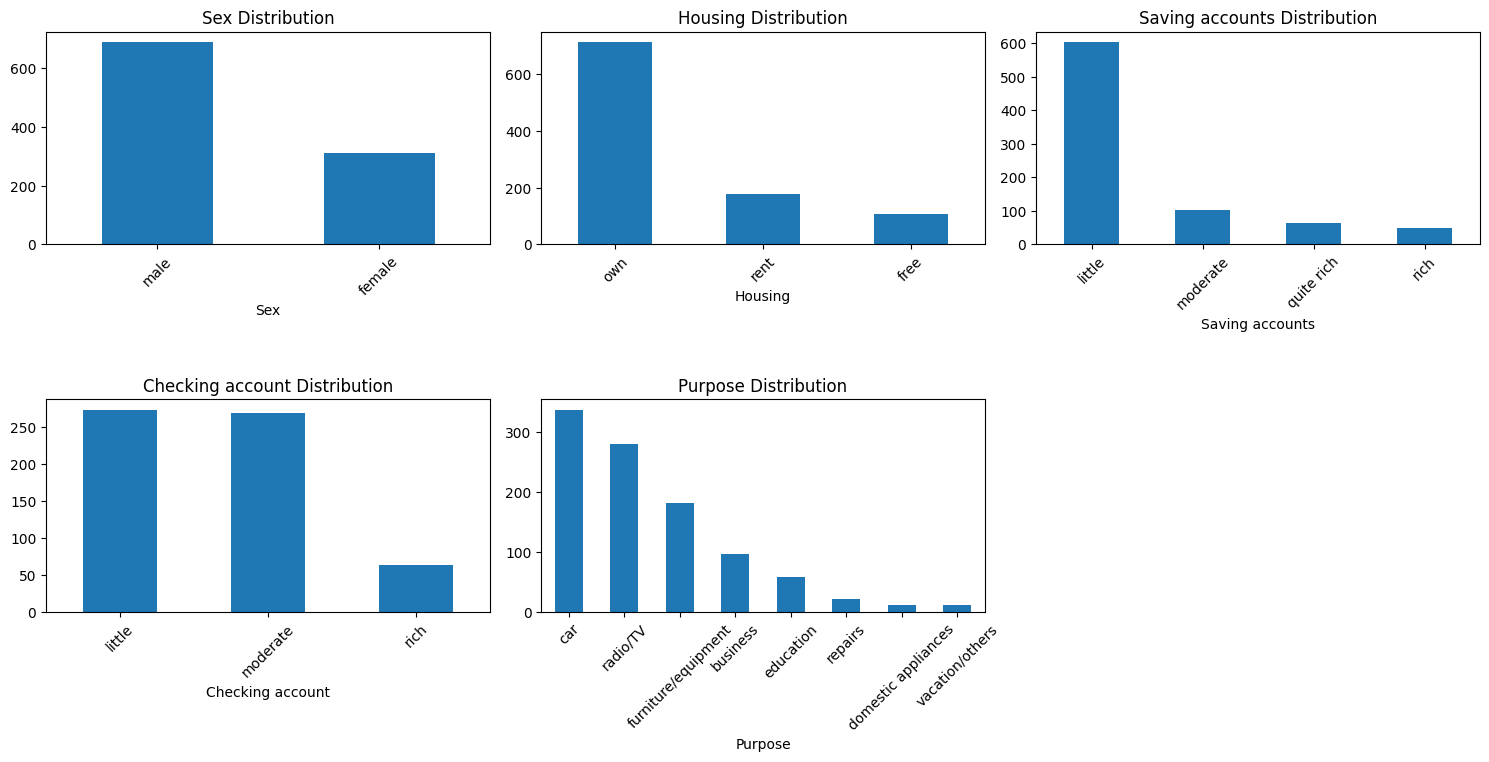

In [6]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols[:min(9, len(categorical_cols))]):
    plt.subplot(3, 3, i+1)
    credit[col].value_counts().plot(kind='bar')
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Data preprocessing


In [10]:
X = credit.drop(target_col, axis=1)
y = credit[target_col]

# Identify categorical and numerical columns in X
cat_cols = X.select_dtypes(include=['object', 'category']).columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

# Create a pipeline with preprocessing and the decision tree
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (800, 9)
Testing data shape: (200, 9)


# 5. Model training

In [12]:
pipeline.fit(X_train, y_train)
dt_classifier = pipeline.named_steps['classifier']
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Training accuracy: {train_score:.4f}")
print(f"Testing accuracy: {test_score:.4f}")

Training accuracy: 1.0000
Testing accuracy: 0.2450


In [13]:
print(f"Difference (training - testing): {train_score - test_score:.4f}")
if train_score - test_score > 0.1:
    print("The model appears to be overfitting. Let's try pruning the tree.")

Difference (training - testing): 0.7550
The model appears to be overfitting. Let's try pruning the tree.


In [14]:
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4, 8],
    'classifier__criterion': ['gini', 'entropy']
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Get the best model
best_pipeline = grid_search.best_estimator_
best_dt = best_pipeline.named_steps['classifier']

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best cross-validation score: 0.35


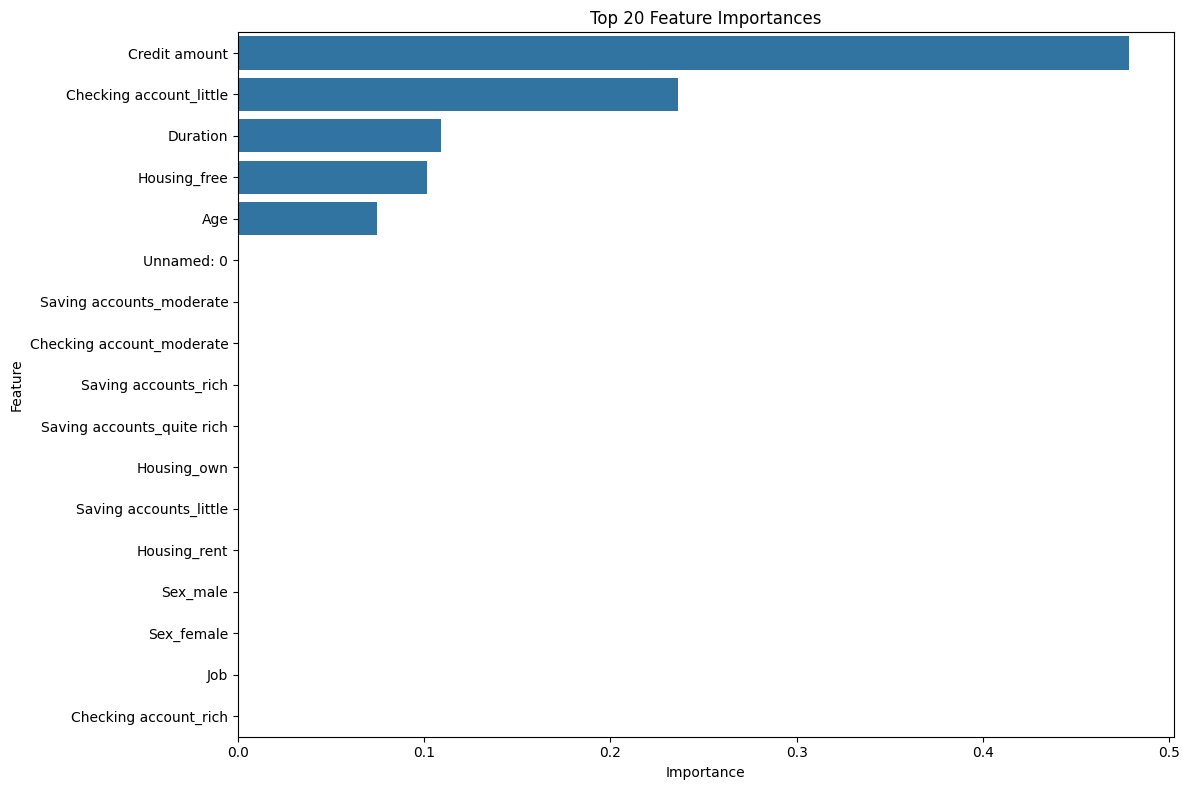

In [15]:
if hasattr(best_dt, 'feature_importances_'):
    # Get feature names after one-hot encoding
    preprocessor = best_pipeline.named_steps['preprocessor']
    cat_features = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(cat_cols)
    feature_names = np.concatenate([num_cols, cat_features])
    
    # Get feature importances
    importances = best_dt.feature_importances_
    
    # Create a DataFrame for visualization
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort by importance
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title('Top 20 Feature Importances')
    plt.tight_layout()
    plt.show()

In [16]:
y_pred = best_pipeline.predict(X_test)
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]

In [17]:
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

Confusion Matrix:
[[ 0  3  0  0  3 13  0  0]
 [ 0 25  0  0  7 35  0  0]
 [ 0  2  0  0  0  1  0  0]
 [ 0  5  0  0  1  6  0  0]
 [ 0 12  0  0  7 17  0  0]
 [ 0  6  0  0 11 39  0  0]
 [ 0  2  0  0  1  2  0  0]
 [ 0  2  0  0  0  0  0  0]]


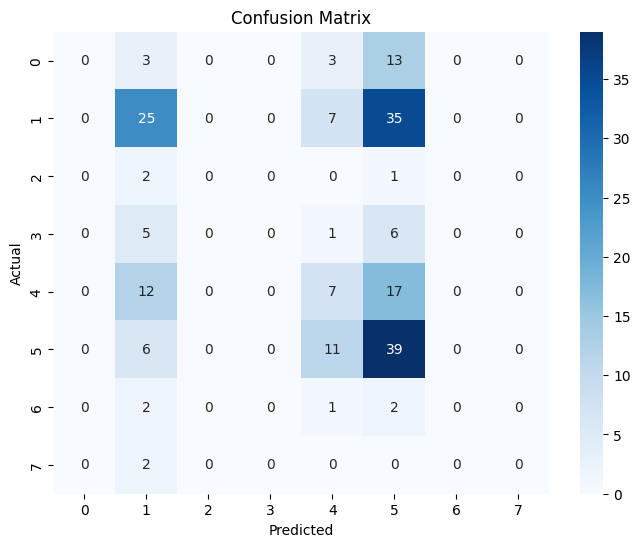

In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [19]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

           business       0.00      0.00      0.00        19
                car       0.44      0.37      0.40        67
domestic appliances       0.00      0.00      0.00         3
          education       0.00      0.00      0.00        12
furniture/equipment       0.23      0.19      0.21        36
           radio/TV       0.35      0.70      0.46        56
            repairs       0.00      0.00      0.00         5
    vacation/others       0.00      0.00      0.00         2

           accuracy                           0.35       200
          macro avg       0.13      0.16      0.13       200
       weighted avg       0.29      0.35      0.30       200




Visualizing the decision tree


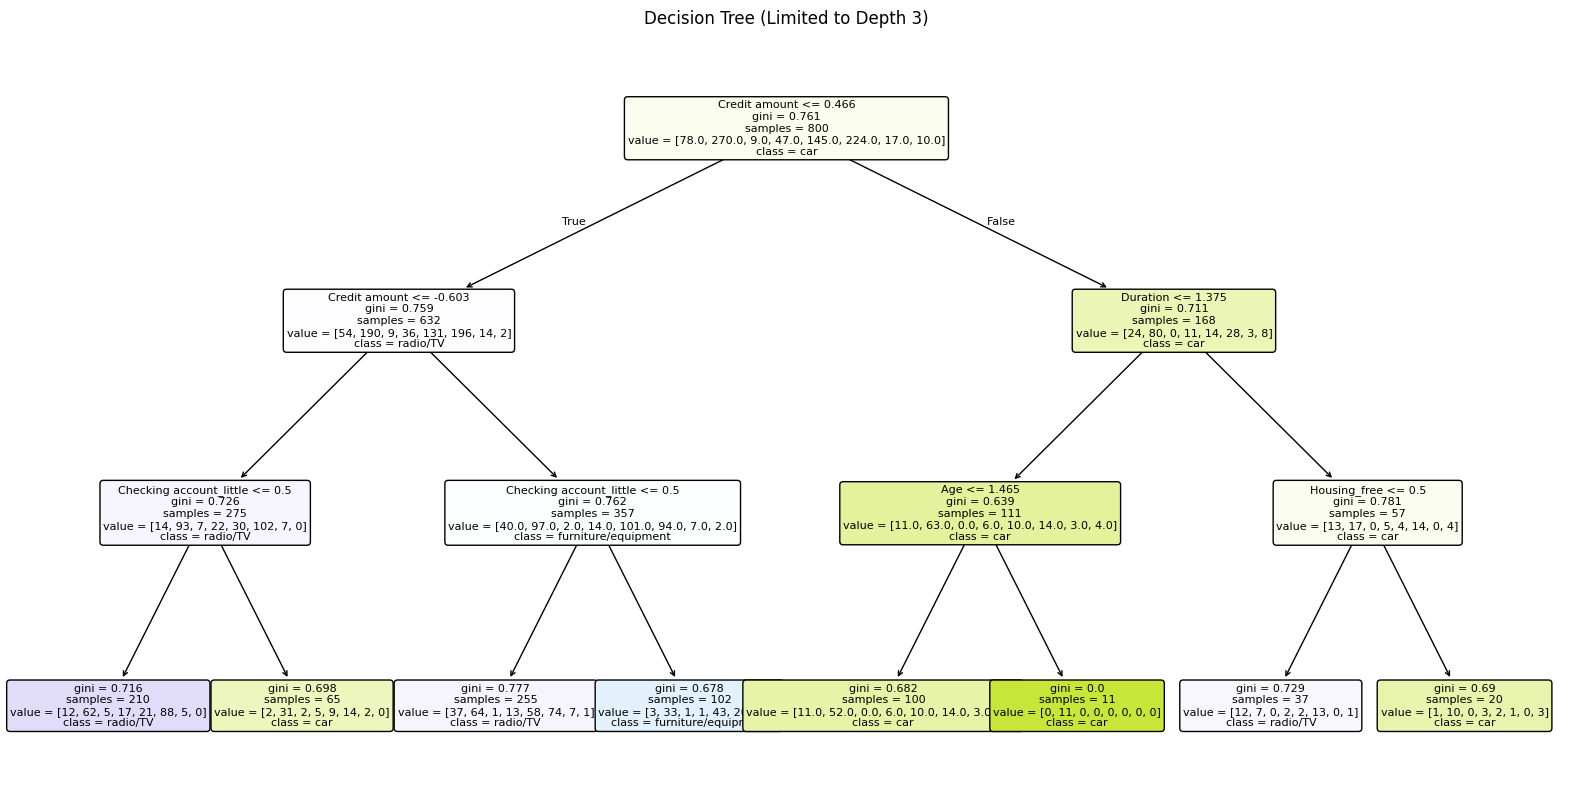

In [23]:
print("\nVisualizing the decision tree")
try:
    plt.figure(figsize=(20, 10))
    # Limit tree depth for visualization
    max_depth_to_plot = min(3, best_dt.tree_.max_depth)
    plot_tree(best_dt, 
              max_depth=max_depth_to_plot, 
              feature_names=feature_names,
              class_names=[str(c) for c in best_dt.classes_],
              filled=True, 
              rounded=True, 
              fontsize=8)
    plt.title(f'Decision Tree (Limited to Depth {max_depth_to_plot})')
    plt.show()
except:
    print("Tree visualization failed. Try exporting to a file instead.")

# 6. Summary


## Project Overview
In this project, I used Decision Trees to predict the purpose of loans from the German Credit Risk dataset. Decision trees are simple but powerful algorithms that make decisions by asking a series of yes/no questions about the data.

## About the Data
- The dataset contained 1,000 loan applications with 9 features
- Features included both numerical data (age, credit amount, duration) and categorical data (sex, housing type, checking account status)
- Some features had missing values, especially in the "Saving accounts" (183 missing) and "Checking account" (394 missing) columns
- The target variable was the loan purpose (business, car, education, etc.)

## What I Discovered About Decision Trees
- Decision trees automatically identify the most important features for making predictions
- They're prone to overfitting - my initial model had 100% accuracy on training data but only 24.5% on test data!
- This huge gap (75.5%) between training and testing accuracy is a classic sign of overfitting
- Pruning (limiting tree depth and requiring more samples per split) helps prevent overfitting

## Hyperparameter Tuning Results
- I used GridSearchCV to find the best tree configuration
- Best parameters: max_depth=3, min_samples_leaf=1, min_samples_split=2, criterion='gini'
- This means a shallow tree with just 3 levels of decisions worked best
- Cross-validation score: 35% accuracy (much lower than KNN on Iris, but this is a harder problem)

## Feature Importance Analysis
- Credit amount was by far the most important feature (contributed ~45% to decisions)
- Checking account status was the second most important (~20%)
- Duration of the loan was third most important (~12%)
- Age and housing type also provided useful information
- Sex and job type had almost no predictive value for loan purpose

## Model Performance
- The pruned tree reached 35% accuracy on the test set
- It performed best at identifying car loans (40% F1-score) and radio/TV loans (46% F1-score)
- It struggled with less common loan purposes like domestic appliances and education
- The confusion matrix showed that many loans were misclassified as radio/TV loans

## Why This Matters
This project taught me that sometimes simpler models (shallow trees) perform better than complex ones, and that feature importance analysis can provide valuable insights about what factors actually matter in making predictions. I also learned that balancing model complexity against generalization ability is crucial for real-world applications.